In [1]:
##4QAM, 16QAM, 64QAM, BPSK, 8PSK.

In [406]:
import keras
from keras import backend as K
from keras.layers import Layer
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras import optimizers, regularizers
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [417]:
#Definitions to automatically generate symbols of QAM and M-Ary PSK
def gray_code(n):
    if n < 1:
        g = []
    else:
        g = ['0', '1']
        n -= 1
        while n > 0:
            k = len(g)
            for i in range(k-1, -1, -1):
                char = '1' + g[i]
                g.append(char)
            for i in range(k-1, -1, -1):
                g[i] = '0' + g[i]
            n -= 1
    return g

class BasicModem:
    def TX(self, payload_data): #String type input
        syms_out = np.zeros(int(len(payload_data)/self.bit_num), dtype=np.complex64)
        cnt = 0
        for i in range(0, len(payload_data) - self.bit_num, self.bit_num):
            syms_out[cnt] = self.inv_dict[payload_data[i:i+self.bit_num]]
            cnt += 1
        return syms_out

class QAM(BasicModem):
    def __init__(self, NUM_SYMBOLS = 4, SAMP_RATE = 1):
        self.NUM_SYMBOLS = NUM_SYMBOLS
        self.SAMP_RATE = SAMP_RATE
        dim_iq_axis = int(np.sqrt(NUM_SYMBOLS))
        self.coords = []
        self.symbols = gray_code(np.log2(NUM_SYMBOLS))
        MAX_ENERGY = np.sqrt(2) #For QAM with coordinates at (x=1,y=1), normalized energy: divide by sqrt(2)
        x = np.linspace(-1, 1, dim_iq_axis, dtype='complex64')
        x, y = np.meshgrid(x, x)
        self.coords = (x + y * 1j).flatten()
        self.dict = dict(zip(self.coords, self.symbols))
        self.inv_dict = dict(zip(self.symbols, self.coords))
        self.bit_num = int(np.log2(NUM_SYMBOLS))

class PSK(BasicModem):
    def __init__(self, NUM_SYMBOLS = 8, SAMP_RATE = 1):
        self.NUM_SYMBOLS = NUM_SYMBOLS
        self.SAMP_RATE = SAMP_RATE
        self.coords = np.zeros(NUM_SYMBOLS, dtype='complex64')
        self.symbols = gray_code(np.log2(NUM_SYMBOLS))
        cnt = 0
        for i in np.arange(0, 2*np.pi, 2*np.pi/NUM_SYMBOLS):
            #i is the phase
            self.coords[cnt] =  1*np.exp(1j*i)
            cnt += 1
        #Above generates an array with the approximate locations of the symbols.
        self.dict = dict(zip(self.coords, self.symbols))
        self.inv_dict = dict(zip(self.symbols, self.coords))
        self.bit_num = int(np.log2(NUM_SYMBOLS))
        print(self.dict)

class rayleigh_multipath:
    """ a multipath channel with Rayleigh fading and AWGN """
    def __init__(self, var_awgn, var_rayleigh, pdp):
        self.sigma_awgn = np.sqrt(var_awgn)
        self.sigma_rayleigh = np.sqrt(var_rayleigh)
        self.pdp = np.array(pdp)
        self.l = self.pdp.size-1
        self.update_cir()

    def update_cir(self):
        """ generate a new CIR from the PDP with Rayleigh fading """
        self.cir = np.sqrt(np.array(self.pdp))
        randray = np.random.rayleigh(self.sigma_rayleigh, self.cir.size)
        self.cir = self.cir*randray

    def awgn(self, symbols):
        """ add white Gaussian noise """
        real_noise = np.random.randn(symbols.size)
        imag_noise = np.random.randn(symbols.size)
        noise = real_noise+1j*imag_noise
        return symbols+self.sigma_awgn*noise

    def apply_cir(self, symbols):
        """ convolve the symbols with the CIR """
        if self.l != 0:
            self.old_symbols = symbols[-self.l:]
        # apply the cir
        symbols = np.convolve(symbols, self.cir)
        return symbols 


In [408]:
myqam4 = QAM(NUM_SYMBOLS=4)
myqam16 = QAM(NUM_SYMBOLS=16)
myqam64 = QAM(NUM_SYMBOLS=64)
myBPSK = PSK(NUM_SYMBOLS = 2)
myPSK8 = PSK(NUM_SYMBOLS = 16)
myqam4.TX('100100')

{(1+0j): '0', (-1+1.2246469e-16j): '1'}
{(1+0j): '0000', (0.9238795+0.38268343j): '0001', (0.70710677+0.70710677j): '0011', (0.38268343+0.9238795j): '0010', (6.123234e-17+1j): '0110', (-0.38268343+0.9238795j): '0111', (-0.70710677+0.70710677j): '0101', (-0.9238795+0.38268343j): '0100', (-1+1.2246469e-16j): '1100', (-0.9238795-0.38268343j): '1101', (-0.70710677-0.70710677j): '1111', (-0.38268343-0.9238795j): '1110', (-1.8369701e-16-1j): '1010', (0.38268343-0.9238795j): '1011', (0.70710677-0.70710677j): '1001', (0.9238795-0.38268343j): '1000'}


array([1.+1.j, 1.-1.j, 0.+0.j], dtype=complex64)

In [409]:
# Authors: CommPy contributors
# License: BSD 3-Clause

"""
==================================================
Modulation Demodulation (:mod:`commpy.modulation`)
==================================================
.. autosummary::
   :toctree: generated/
   PSKModem             -- Phase Shift Keying (PSK) Modem.
   QAMModem             -- Quadrature Amplitude Modulation (QAM) Modem.
   ofdm_tx              -- OFDM Transmit Signal Generation
   ofdm_rx              -- OFDM Receive Signal Processing
   mimo_ml              -- MIMO Maximum Likelihood (ML) Detection.
   kbest                -- MIMO K-best Schnorr-Euchner Detection.
   bit_lvl_repr         -- Bit level representation.
   max_log_approx       -- Max-log approximation.
"""
from itertools import product

import matplotlib.pyplot as plt
from numpy import arange, array, zeros, pi, cos, sin, sqrt, log2, argmin, \
    hstack, repeat, tile, dot, shape, concatenate, exp, \
    log, vectorize, empty, eye, kron, inf
from numpy.fft import fft, ifft
from numpy.linalg import qr, norm

from commpy.utilities import bitarray2dec, dec2bitarray

__all__ = ['PSKModem', 'QAMModem', 'ofdm_tx', 'ofdm_rx', 'mimo_ml', 'kbest', 'bit_lvl_repr', 'max_log_approx']


class Modem:
    def modulate(self, input_bits):
        """ Modulate (map) an array of bits to constellation symbols.
        Parameters
        ----------
        input_bits : 1D ndarray of ints
            Inputs bits to be modulated (mapped).
        Returns
        -------
        baseband_symbols : 1D ndarray of complex floats
            Modulated complex symbols.
        """
        mapfunc = vectorize(lambda i:
                            self.constellation[bitarray2dec(input_bits[i:i + self.num_bits_symbol])])

        baseband_symbols = mapfunc(arange(0, len(input_bits), self.num_bits_symbol))

        return baseband_symbols

    def demodulate(self, input_symbols, demod_type, noise_var=0):
        """ Demodulate (map) a set of constellation symbols to corresponding bits.
        Parameters
        ----------
        input_symbols : 1D ndarray of complex floats
            Input symbols to be demodulated.
        demod_type : string
            'hard' for hard decision output (bits)
            'soft' for soft decision output (LLRs)
        noise_var : float
            AWGN variance. Needs to be specified only if demod_type is 'soft'
        Returns
        -------
        demod_bits : 1D ndarray of ints
            Corresponding demodulated bits.
        """
        if demod_type == 'hard':
            index_list = map(lambda i: argmin(abs(input_symbols[i] - self.constellation)),
                             range(0, len(input_symbols)))
            demod_bits = array([dec2bitarray(i, self.num_bits_symbol) for i in index_list]).reshape(-1)

        elif demod_type == 'soft':
            demod_bits = zeros(len(input_symbols) * self.num_bits_symbol)
            for i in arange(len(input_symbols)):
                current_symbol = input_symbols[i]
                for bit_index in arange(self.num_bits_symbol):
                    llr_num = 0
                    llr_den = 0
                    for const_index in self.symbol_mapping:
                        if (const_index >> bit_index) & 1:
                            llr_num = llr_num + exp(
                                (-abs(current_symbol - self.constellation[const_index]) ** 2) / noise_var)
                        else:
                            llr_den = llr_den + exp(
                                (-abs(current_symbol - self.constellation[const_index]) ** 2) / noise_var)
                    demod_bits[i * self.num_bits_symbol + self.num_bits_symbol - 1 - bit_index] = log(llr_num / llr_den)
        else:
            raise ValueError('demod_type must be "hard" or "soft"')

        return demod_bits

    def plot_constellation(self):
        """ Plot the constellation """
        # init some arrays
        beta = self.num_bits_symbol
        numbit = '0' + str(beta) + 'b'
        Bin = []
        mot = []
        const = []

        # creation of w array
        reel = [pow(2, i) for i in range(beta // 2 - 1, -1, -1)]
        im = [1j * pow(2, i) for i in range(beta // 2 - 1, -1, -1)]
        w = concatenate((reel, im), axis=None)

        listBin = [format(i, numbit) for i in range(2 ** beta)]
        for e in listBin:
            for i in range(beta):
                Bin.append(ord(e[i]) - 48)
                if ord(e[i]) - 48 == 0:
                    mot.append(-1)
                else:
                    mot.append(1)
            const.append(dot(w, mot))
            mot = []
        symb = self.modulate(Bin)

        # plot the symbols
        x = symb.real
        y = symb.imag

        plt.plot(x, y, '+', linewidth=4)
        for i in range(len(x)):
            plt.text(x[i], y[i], listBin[i])

        plt.title('Constellation')
        plt.grid()
        plt.show()


class PSKModem(Modem):
    """ Creates a Phase Shift Keying (PSK) Modem object. """

    Es = 1

    def _constellation_symbol(self, i):
        return cos(2 * pi * (i - 1) / self.m) + sin(2 * pi * (i - 1) / self.m) * (0 + 1j)

    def __init__(self, m):
        """ Creates a Phase Shift Keying (PSK) Modem object.
        Parameters
        ----------
        m : int
            Size of the PSK constellation.
        """
        self.m = m
        self.num_bits_symbol = int(log2(self.m))
        self.symbol_mapping = arange(self.m)
        self.constellation = list(map(self._constellation_symbol,
                                      self.symbol_mapping))


class QAMModem(Modem):
    """ Creates a Quadrature Amplitude Modulation (QAM) Modem object."""

    def _constellation_symbol(self, i):
        return (2 * i[0] - 1) + (2 * i[1] - 1) * (1j)

    def __init__(self, m):
        """ Creates a Quadrature Amplitude Modulation (QAM) Modem object.
        Parameters
        ----------
        m : int
            Size of the QAM constellation.
        """

        self.m = m
        self.num_bits_symbol = int(log2(self.m))
        self.symbol_mapping = arange(self.m)
        mapping_array = arange(1, sqrt(self.m) + 1) - (sqrt(self.m) / 2)
        self.constellation = list(map(self._constellation_symbol,
                                      list(product(mapping_array, repeat=2))))
        self.Es = 2 * (self.m - 1) / 3


def ofdm_tx(x, nfft, nsc, cp_length):
    """ OFDM Transmit signal generation """

    nfft = float(nfft)
    nsc = float(nsc)
    cp_length = float(cp_length)
    ofdm_tx_signal = array([])

    for i in range(0, shape(x)[1]):
        symbols = x[:, i]
        ofdm_sym_freq = zeros(nfft, dtype=complex)
        ofdm_sym_freq[1:(nsc / 2) + 1] = symbols[nsc / 2:]
        ofdm_sym_freq[-(nsc / 2):] = symbols[0:nsc / 2]
        ofdm_sym_time = ifft(ofdm_sym_freq)
        cp = ofdm_sym_time[-cp_length:]
        ofdm_tx_signal = concatenate((ofdm_tx_signal, cp, ofdm_sym_time))

    return ofdm_tx_signal


def ofdm_rx(y, nfft, nsc, cp_length):
    """ OFDM Receive Signal Processing """

    num_ofdm_symbols = int(len(y) / (nfft + cp_length))
    x_hat = zeros([nsc, num_ofdm_symbols], dtype=complex)

    for i in range(0, num_ofdm_symbols):
        ofdm_symbol = y[i * nfft + (i + 1) * cp_length:(i + 1) * (nfft + cp_length)]
        symbols_freq = fft(ofdm_symbol)
        x_hat[:, i] = concatenate((symbols_freq[-nsc / 2:], symbols_freq[1:(nsc / 2) + 1]))

    return x_hat


def mimo_ml(y, h, constellation):
    """ MIMO ML Detection.
    parameters
    ----------
    y : 1D ndarray of complex floats
        Received complex symbols (shape: num_receive_antennas x 1)
    h : 2D ndarray of complex floats
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    constellation : 1D ndarray of complex floats
        Constellation used to modulate the symbols
    """
    _, n = h.shape
    m = len(constellation)
    x_ideal = empty((n, pow(m, n)), complex)
    for i in range(0, n):
        x_ideal[i] = repeat(tile(constellation, pow(m, i)), pow(m, n - i - 1))
    min_idx = argmin(norm(y[:, None] - dot(h, x_ideal), axis=0))
    x_r = x_ideal[:, min_idx]

    return x_r


def kbest(y, h, constellation, K, noise_var=0, output_type='hard', demode=None):
    """ MIMO K-best Schnorr-Euchner Detection.
    Reference: Zhan Guo and P. Nilsson, 'Algorithm and implementation of the K-best sphere decoding for MIMO detection',
        IEEE Journal on Selected Areas in Communications, vol. 24, no. 3, pp. 491-503, Mar. 2006.
    Parameters
    ----------
    y : 1D ndarray
        Received complex symbols (length: num_receive_antennas)
    h : 2D ndarray
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    constellation : 1D ndarray of floats
        Constellation used to modulate the symbols
    K : positive integer
        Number of candidates kept at each step
    noise_var : positive float
        Noise variance.
        *Default* value is 0.
    output_type : str
        'hard': hard output i.e. output is a binary word
        'soft': soft output i.e. output is a vector of Log-Likelihood Ratios.
        *Default* value is 'hard'
    demode : function with prototype binary_word = demode(point)
        Function that provide the binary word corresponding to a symbol vector.
    Returns
    -------
    x : 1D ndarray of constellation points or of Log-Likelihood Ratios.
        Detected vector (length: num_receive_antennas).
    raises
    ------
    ValueError
                If h has more columns than rows.
                If output_type is something else than 'hard' or 'soft'
    """
    nb_tx, nb_rx = h.shape
    if nb_rx > nb_tx:
        raise ValueError('h has more columns than rows')

    # QR decomposition
    q, r = qr(h)
    yt = q.conj().T.dot(y)

    # Initialization
    m = len(constellation)
    nb_can = 1

    if isinstance(constellation[0], complex):
        const_type = complex
    else:
        const_type = float
    X = empty((nb_rx, K * m), dtype=const_type)  # Set of current candidates
    d = tile(yt[:, None], (1, K * m))  # Corresponding distance vector
    d_tot = zeros(K * m, dtype=float)  # Corresponding total distance
    hyp = empty(K * m, dtype=const_type)  # Hypothesis vector

    # Processing
    for coor in range(nb_rx - 1, -1, -1):
        nb_hyp = nb_can * m

        # Copy best candidates m times
        X[:, :nb_hyp] = tile(X[:, :nb_can], (1, m))
        d[:, :nb_hyp] = tile(d[:, :nb_can], (1, m))
        d_tot[:nb_hyp] = tile(d_tot[:nb_can], (1, m))

        # Make hypothesis
        hyp[:nb_hyp] = repeat(constellation, nb_can)
        X[coor, :nb_hyp] = hyp[:nb_hyp]
        d[coor, :nb_hyp] -= r[coor, coor] * hyp[:nb_hyp]
        d_tot[:nb_hyp] += abs(d[coor, :nb_hyp]) ** 2

        # Select best candidates
        argsort = d_tot[:nb_hyp].argsort()
        nb_can = min(nb_hyp, K)  # Update number of candidate

        # Update accordingly
        X[:, :nb_can] = X[:, argsort[:nb_can]]
        d[:, :nb_can] = d[:, argsort[:nb_can]]
        d[:coor, :nb_can] -= r[:coor, coor, None] * hyp[argsort[:nb_can]]
        d_tot[:nb_can] = d_tot[argsort[:nb_can]]

    if output_type == 'hard':
        return X[:, 0]
    elif output_type == 'soft':
        return max_log_approx(y, h, noise_var, X[:, :nb_can], demode)
    else:
        raise ValueError('output_type must be "hard" or "soft"')


def bit_lvl_repr(H, w):
    """ Bit-level representation of matrix H with weights w.
    parameters
    ----------
    H   :   2D ndarray (shape : nb_rx, nb_tx)
            Channel Matrix.
    w   :   1D ndarray of complex (length : beta)
            Bit level representation weights. The length must be even.
    return
    ------
    A : 2D nbarray (shape : nb_rx, nb_tx*beta)
        Channel matrix adapted to the bit-level representation.
    """
    beta = len(w)
    if beta % 2 == 0:
        m, n = H.shape
        In = eye(n, n)
        kr = kron(In, w)
        return dot(H, kr)
    else:
        raise ValueError('Beta must be even.')


def max_log_approx(y, h, noise_var, pts_list, demode):
    """ Max-log demode
    parameters
    ----------
    y : 1D ndarray
        Received symbol vector (length: num_receive_antennas)
    h : 2D ndarray
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    noise_var : positive float
        Noise variance
    pts_list : 2D ndarray of constellation points
        Set of points to compute max log approximation (points are column-wise).
        (shape: num_receive_antennas x num_points)
    demode : function with prototype binary_word = demode(point)
        Function that provide the binary word corresponding to a symbol vector.
    return
    ------
    LLR : 1D ndarray of floats
        Log-Likelihood Ratio for each bit (same length as the return of decode)
    """
    # Decode all pts
    nb_pts = pts_list.shape[1]
    bits = demode(pts_list.reshape(-1, order='F')).reshape(nb_pts, -1)  # Set of binary words (one word by row)

    # Prepare LLR computation
    nb_bits = bits.shape[1]
    LLR = empty(nb_bits)

    # Loop for each bit
    for k in range(nb_bits):
        # Select pts based on the k-th bit in the corresponding word
        pts0 = pts_list.compress(bits[:, k] == 0, axis=1)
        pts1 = pts_list.compress(bits[:, k] == 1, axis=1)

        # Compute the norms and add inf to handle empty set of points
        norms0 = hstack((norm(y[:, None] - h.dot(pts0), axis=0) ** 2, inf))
        norms1 = hstack((norm(y[:, None] - h.dot(pts1), axis=0) ** 2, inf))

        # Compute LLR
        LLR[k] = min(norms0) - min(norms1)

    return -LLR / (2 * noise_var)

In [410]:
qam4 = QAMModem(4)
qam16 = QAMModem(16)
qam64 = QAMModem(64)
bpsk = PSKModem(2)
psk8 = PSKModem(8)
'''Note that the QAM soft-demodulators simply dont work due to a divide by zero error!'''

'Note that the QAM soft-demodulators simply dont work due to a divide by zero error!'

In [411]:
from scipy import special
def P_error_mqam(M, Es_No_Ratio, Es = None, No = None):
    if Es != None and No != None:
        return 2*(1-1/(np.sqrt(M)))*special.erfc(k*np.sqrt(Es/No))
    else:
        return 2*(1-1/(np.sqrt(M)))*special.erfc(k*np.sqrt(Es_No_Ratio))

def P_error_mpsk(M, Es_No_Ratio, Es=None, No = None):
    if Es != None and No != None:
        return 2 * special.erfc(np.sqrt(2*(Es/No)*sin(np.pi/M)**2))
    else:
        return 2 * special.erfc(np.sqrt(2*(Es_No_Ratio)*sin(np.pi/M)**2))

def P_error_bpsk(Es_No_Ratio, Es = None, No = None):
    if Es != None and No != None:
        return 0.5*special.erfc(np.sqrt(Es_No_Ratio))
    else:
        return 0.5*special.erfc(np.sqrt(Es/No))

def calc_llr_wrong(symbol_mapping, r, s, h = np.complex64(1.0), No = 1, var = 1):
    #https://arxiv.org/pdf/1903.04656.pdf
    #I might be doing this wrong, this might supposed to be Probability(received symbol | bit of i = 1)
    null_symbols = []
    null_bits = []
    my_symbol = []
    my_bits = []
    for key,value in symbol_mapping:
        if s == key:
            my_symbol.append(key)
            my_bits.append(value)
        else:
            null_symbol.append(key)
            null_symbol.append(value)
            
    a = np.exp(-1*(np.mag(r-h*my_symbol[0]))/var) #There is only one correct symbol
    
    running_sum = 0.0
    for i in range(null_symbols):
        b = np.exp(-1*(np.mag(r-h*null_symbols[i]))/var)
        running_sum += b
    
def calc_llr_v0(symbol_mapping, r, s, h = np.complex64(1.0), No = 1, var = 1):
    #https://arxiv.org/pdf/1903.04656.pdf
    #I might be doing this wrong, this might supposed to be Probability(received symbol | bit of i = 1)
    #s is the label, r is the received symbol
    null_symbols = []
    null_bits = []
    my_symbol = []
    my_bits = []
    #print(symbol_mapping)
    for key,value in symbol_mapping.items():
        #print("for", s, key)
        if s == key:
            my_symbol.append(key)
            my_bits.append(value)
        else:
            null_symbols.append(key)
            null_bits.append(value)
    #print(my_bits)
    run_sum_1 = 0.0
    run_sum_0 = 0.0
    for bit in my_bits[0]:
        a = np.exp(-1*(np.linalg.norm(r-h*s))/var) #There is only one correct symbol
        #print(a, bit)
        if bit == '0':
            run_sum_0 += a
        else:
            run_sum_1 += a
    
    Li = np.log2(run_sum_1) - np.log2(run_sum_0)
    #If 0: Equally likely
    #print(Li)
    return Li

def has_ith_bit(i = 0, bit = '0', symbol_mapping = {}):
    sym_list = []
    for symbol, bits in symbol_mapping.items():
        if bits[i] == bit:
            sym_list.append(symbol)
    return sym_list

def calc_llr(symbol_mapping, r, h = np.complex64(1.0), var = 1):
    #https://arxiv.org/pdf/1903.04656.pdf
    #I might be doing this wrong, this might supposed to be Probability(received symbol | bit of i = 1)
    #s is the label, r is the received symbol
    Ls = []
    vals = list(symbol_mapping.values())
    for i in range(len(vals[0])):
        soft_symbols_1 = has_ith_bit(i = i, bit = '1', symbol_mapping = symbol_mapping)
        soft_symbols_0 = has_ith_bit(i = i, bit = '0', symbol_mapping = symbol_mapping)
        run_sum_1 = 0.0
        run_sum_0 = 0.0
        for local_s in soft_symbols_1:
            a = np.exp(-1*np.min(1000, np.linalg.norm(r-h*local_s))/var)
            run_sum_1 += a
        for local_s in soft_symbols_0:
            a = np.exp(-1*(np.min(1000, np.linalg.norm(r-h*local_s))/var)) #Minimum is to fix growing exponential bug for each SNR
            run_sum_0 += a
        #print('runs1: ', run_sum_1, 'runs0: ', run_sum_0)
        Li = np.log2(run_sum_1) - np.log2(run_sum_0)
        Ls.append(Li)
    #print(Ls)
    return Ls

    
def soft_demodulate(input_symbols, symbol_mapping, h = np.complex64(1.0), var = 1):
    #Code taken from CommPy: https://github.com/veeresht/CommPy/blob/master/commpy/modulation.py
    list_syms = np.array([ k for k in symbol_mapping.keys() ])
    list_bits = np.array([ v for v in symbol_mapping.values() ])
    str_out = ''
    for i in range(len(input_symbols)):
        llrs = calc_llr(symbol_mapping, input_symbols[i], h = h, var = var)
        for llr in llrs:
            if llr <= 0.0:
                str_out += '0'
            else:
                str_out += '1'
    return str_out

In [419]:
def generateModel(in_shape = 2, bps = 2):
    model = Sequential()
    model.add(Dense(in_shape, input_shape=(in_shape, )))
    model.add(Dense(in_shape*2, input_shape=(in_shape, )))
    #leakyrelu = keras.layers.LeakyReLU(alpha=0.3)
    model.add(Activation('relu'))
    model.add(Dense(bps, input_shape=(bps, ), 
                   kernel_regularizer=regularizers.l2(0.0001)
                    ,
                    activity_regularizer=regularizers.l1(0.0001)))
    return model

In [ ]:
#Sanity Checking
print(myqam4.dict[-1-1j])
print(myqam16.dict[-1-1j])
print('calc_llr:', calc_llr(myqam4.dict, -1-1j, h = 1.0))
print('calc_llr:', calc_llr(myqam4.dict, -0.5+0.75j, h = 1.0))
print('calc_llr:', calc_llr(myqam4.dict, -0.5+0.75j, h = 1.0 + 2j))
print('calc_llr:', calc_llr(myqam16.dict, 0.75+0.75j, h = 1.0))
print('soft: ', soft_demodulate([-1-1j, -1+1j, 1+1j, 1-1j], myqam16.dict, h=1.0))
print('dict:', myqam16.dict)

In [421]:
#Sanity Checking
print(myPSK8.dict)
print('calc_llr:', calc_llr(myPSK8.dict, 1, h = 1.0))
print('calc_llr:', calc_llr(myPSK8.dict, -1, h = 1.0))
print('calc_llr:', calc_llr(myBPSK.dict, 1, h = 1.0))
print('calc_llr:', calc_llr(myBPSK.dict, -1, h = 1.0))
print('soft: ', soft_demodulate([1, 1, -1, -1, 1, 1], myBPSK.dict, h=1.0))
print('dict:', myBPSK.dict)

{(1+0j): '0000', (0.9238795+0.38268343j): '0001', (0.70710677+0.70710677j): '0011', (0.38268343+0.9238795j): '0010', (6.123234e-17+1j): '0110', (-0.38268343+0.9238795j): '0111', (-0.70710677+0.70710677j): '0101', (-0.9238795+0.38268343j): '0100', (-1+1.2246469e-16j): '1100', (-0.9238795-0.38268343j): '1101', (-0.70710677-0.70710677j): '1111', (-0.38268343-0.9238795j): '1110', (-1.8369701e-16-1j): '1010', (0.38268343-0.9238795j): '1011', (0.70710677-0.70710677j): '1001', (0.9238795-0.38268343j): '1000'}
calc_llr: [-0.45407425350371855, -1.6281609788657778, -0.6606638425187255, -0.19617467218996398]
calc_llr: [0.45407425350371855, 1.6281609788657778, -0.6606638425187259, -0.19617467218996398]
calc_llr: [-2.8853900817779268]
calc_llr: [2.8853900817779268]
soft:  001100
dict: {(1+0j): '0', (-1+1.2246469e-16j): '1'}


[100.0, 9.999999999999998, 2.5118864315095797, 0.6309573444801932, 0.39810717055349726, 0.25118864315095807, 0.1, 0.010000000000000002, 0.00251188643150958, 0.0009999999999999998, 0.0001]
QAM
X
 [[ 5.25791036 -0.80631438]
 [-2.07302758 10.68735425]
 [-2.24343106  2.35125642]
 ...
 [-3.24397638 -7.31437419]
 [ 4.36269287 -6.10776402]
 [-5.99929058  1.97646254]] 
Y
 [[-0.00444675  0.00083962]
 [ 0.02821594  0.00054724]
 [ 0.02086413  0.00438615]
 ...
 [-0.02624399 -0.00143269]
 [-0.02342337  0.00193864]
 [ 0.00912547  0.00142525]]


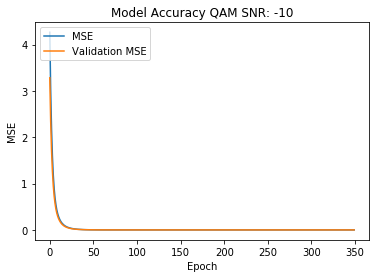

QAM
X
 [[ 2.11114467  3.70740505]
 [ 6.62918496 -1.55350856]
 [-2.39623548 -7.95369694]
 ...
 [ 0.52178433  0.02397813]
 [ 5.17962584 -5.50000091]
 [ 6.27065306 -3.19313679]] 
Y
 [[ 0.24873464 -0.04061329]
 [-0.06732187  0.0156895 ]
 [-0.27488161 -0.01746286]
 ...
 [ 0.00506379 -0.00139984]
 [-0.21124047  0.03325054]
 [-0.13311948  0.02803624]]


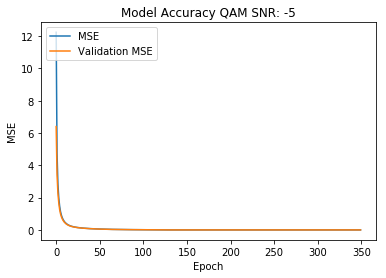

QAM
X
 [[ 3.50504351 -0.52124341]
 [ 0.13984611  0.73942521]
 [-1.49459364 -2.21177102]
 ...
 [ 2.87957287 -0.46142215]
 [-1.44976112  0.25090371]
 [-0.80354191  1.27638421]] 
Y
 [[-0.18989907  0.10749056]
 [ 0.56212842 -0.06027971]
 [-0.97023703 -0.3867205 ]
 ...
 [-0.20801892  0.12310145]
 [ 0.20803939  0.13201556]
 [ 0.92005302  0.42309599]]


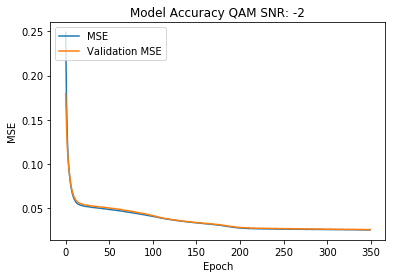

QAM
X
 [[-1.65539721 -0.05517862]
 [ 1.71628298 -0.13213896]
 [-0.89768696 -0.58830338]
 ...
 [ 1.99146286  0.75136938]
 [-2.4096781   0.98522447]
 [-0.10539509 -0.63251206]] 
Y
 [[-0.20255435 -0.1902572 ]
 [-0.47147177  0.4432983 ]
 [-2.47575333 -2.06966662]
 ...
 [ 2.18850123 -2.02095987]
 [ 2.27722094  2.0905856 ]
 [-1.95694774 -0.30638049]]


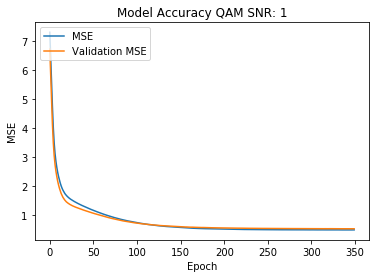

QAM
X
 [[-0.834899    0.96222399]
 [ 0.08784518  1.08349915]
 [-1.05073964  0.06214973]
 ...
 [ 0.99359077  0.82881327]
 [-1.05521546  0.50178453]
 [-1.10572768 -0.70670616]] 
Y
 [[ 6.32371292  5.26196087]
 [ 4.77135911 -0.60122546]
 [ 0.44013194  0.42475651]
 ...
 [ 5.86979445 -5.28753254]
 [ 3.55280783  3.35696011]
 [-4.96963516 -4.63571935]]


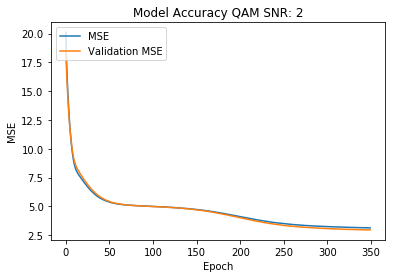

QAM
X
 [[-0.87134385  0.32502922]
 [ 0.46215585  0.82748266]
 [-0.91157653 -1.15995889]
 ...
 [ 2.08226394  0.94672214]
 [-0.95457972  1.76931305]
 [-0.62551426  0.66406245]] 
Y
 [[  3.67662005   3.60060435]
 [  7.50082466  -4.97613283]
 [-11.28870268  -9.50381019]
 ...
 [  6.5645765   -6.52209963]
 [ 11.37124305   7.54098551]
 [  6.80434299   5.77053102]]


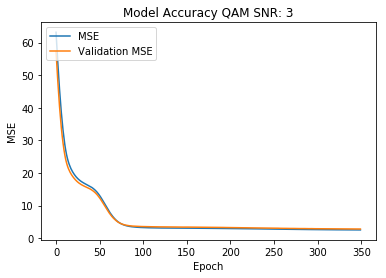

QAM
X
 [[-0.99420717  0.88475081]
 [ 1.15887881  0.5205812 ]
 [-0.20368608 -1.16033598]
 ...
 [ 1.499541    0.98481994]
 [-0.97654472  1.45708461]
 [-0.33336542 -0.06637629]] 
Y
 [[ 25.52627388  25.12189881]
 [ 14.77028568 -14.76874247]
 [-21.28300736  -5.79993371]
 ...
 [ 22.31769253 -22.30221787]
 [ 28.84547395  22.64531576]
 [ -1.58861163  -1.56295847]]


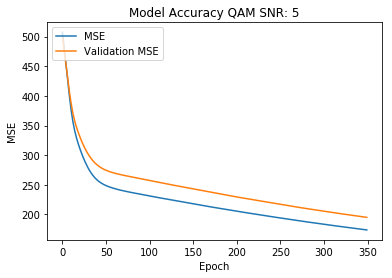

QAM
X
 [[-0.96265715  1.15567158]
 [ 0.89500333  0.89283548]
 [-0.91821254 -1.0276471 ]
 ...
 [ 0.85097822  0.91701623]
 [-1.06594114  1.01721699]
 [ 0.04772402 -0.19548647]] 
Y
 [[ 287.94853062  260.9450515 ]
 [ 251.85371215 -251.00918875]
 [-280.31016019 -264.31293603]
 ...
 [ 252.7934481  -242.69871027]
 [ 281.34612812  281.3339674 ]
 [ -40.64987869   10.72617432]]


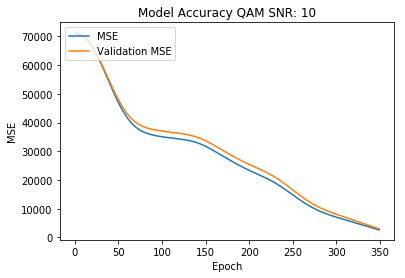

QAM


d:\applications\python3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log2


X
 [[-1.07591335  1.04470722]
 [ 1.00545517  0.97553523]
 [-0.91842324 -1.01583851]
 ...
 [ 1.00031668  1.00198629]
 [-1.00789845  1.09792174]
 [-0.00461433  0.02170441]] 
Y
 [[        inf         inf]
 [        inf        -inf]
 [       -inf        -inf]
 ...
 [        inf        -inf]
 [        inf         inf]
 [17.66344233  3.78877443]]


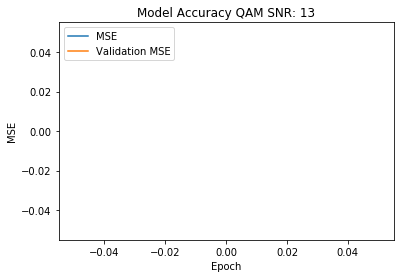

QAM


d:\applications\python3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


X
 [[-1.0302937   1.03384633]
 [ 1.01044242  0.97606523]
 [-1.06882251 -0.95216211]
 ...
 [ 0.96837783  0.99161273]
 [-0.96554363  0.98745155]
 [-0.03727403 -0.05210217]] 
Y
 [[ inf  inf]
 [ inf -inf]
 [-inf -inf]
 ...
 [ inf -inf]
 [ inf  inf]
 [ nan  nan]]


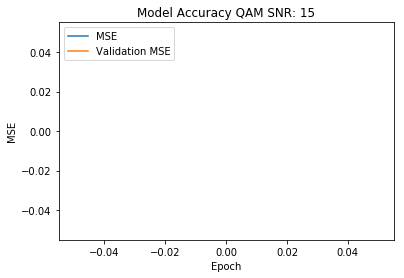

QAM
X
 [[-0.98947039  1.01589331]
 [ 0.99487674  1.00709047]
 [-1.00697503 -1.00283029]
 ...
 [ 0.99392684  1.01174232]
 [-0.9851619   1.02025056]
 [ 0.01282633 -0.0174139 ]] 
Y
 [[ inf  inf]
 [ inf -inf]
 [-inf -inf]
 ...
 [ inf -inf]
 [ inf  inf]
 [ nan  nan]]


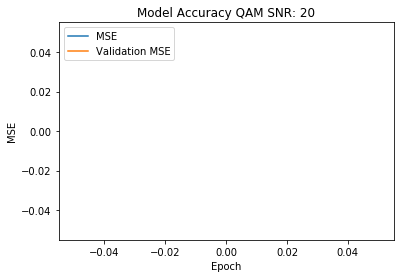

QAM16
X
 [[  2.21946636   0.26972084]
 [ -3.66689858  -9.7783552 ]
 [  1.45366026   4.42427064]
 ...
 [ -5.15979131  -4.08974849]
 [ -8.53361842   1.724758  ]
 [-18.28254861  -6.49360814]] 
Y
 [[ 2.35316338e-03  2.93642310e-03 -2.34888159e-04  2.57810354e-04]
 [-1.79752927e-02  2.08707231e-05 -2.23118882e-04  5.30588434e-04]
 [ 1.80790342e-02  9.51993041e-05 -4.28424315e-04  1.24113565e-03]
 ...
 [-1.19515175e-02  5.67200380e-04 -4.96911208e-04  3.31611648e-04]
 [ 3.81983067e-03  7.07207916e-04  1.52744289e-04 -2.80573021e-05]
 [-6.44148059e-03  2.86356555e-04 -1.24070237e-04 -1.96524890e-05]]


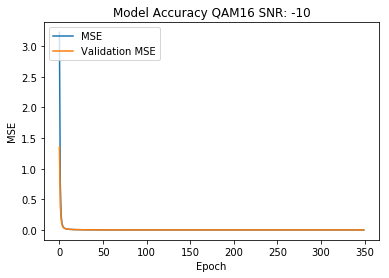

QAM16
X
 [[ 3.99302043 -0.98609942]
 [ 3.05617197  0.03995592]
 [-0.87231085 -5.06577281]
 ...
 [ 2.09581771  4.19189696]
 [-0.21061958 -1.78884482]
 [ 0.28231248 -0.62529216]] 
Y
 [[-4.68782813e-02  1.45946420e-02  4.71357281e-03 -4.63779659e-03]
 [ 2.57725349e-03  2.18868052e-02 -2.98137056e-04 -4.82142148e-03]
 [-1.87710574e-01 -5.52567234e-03 -3.19235994e-03  1.21362462e-02]
 ...
 [ 1.70901724e-01 -2.33880524e-03 -8.04621937e-03  9.60926552e-03]
 [-1.75247158e-01  9.24249570e-05 -4.55096759e-03  3.75184781e-02]
 [-1.04538406e-01  4.36512082e-02  2.40888645e-03  6.07663471e-02]]


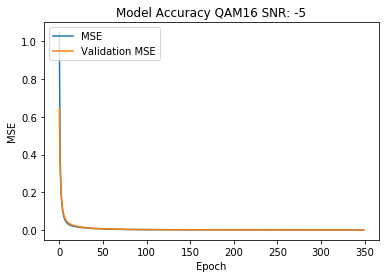

QAM16
X
 [[ 2.16473536  4.64829646]
 [-0.8041159   0.42510204]
 [-2.40570436  0.88005537]
 ...
 [-0.27582521 -4.22023483]
 [ 2.15119911  0.83591326]
 [-0.55768145 -0.80205618]] 
Y
 [[ 6.93201327e-01 -7.31618655e-02 -5.84664875e-02  2.21002159e-02]
 [ 2.90419471e-01  2.14525791e-01 -3.16133741e-04  8.90328151e-02]
 [ 2.79145489e-01  7.91996218e-02  5.08886709e-02 -6.94646992e-02]
 ...
 [-7.52441786e-01 -9.34719873e-02 -1.08425604e-02  6.35068158e-02]
 [ 2.94911387e-01  8.63802001e-02 -5.31095428e-02 -6.42514771e-02]
 [-4.90508375e-01  9.16633055e-02 -5.32633041e-02  1.74716023e-01]]


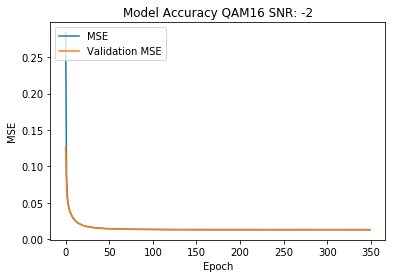

QAM16
X
 [[ 1.16504943 -0.40203594]
 [ 0.10488191  0.7186396 ]
 [-0.29343836  1.3367846 ]
 ...
 [-1.0927787  -0.54232924]
 [ 1.09203353 -0.86966188]
 [-1.13417811  0.87864738]] 
Y
 [[-1.16900933  0.90837185 -0.19615844 -0.72737566]
 [ 1.80775859  0.17308925 -0.05422637  1.17242448]
 [ 2.64144395 -0.81325442  0.4430204   0.93432742]
 ...
 [-1.47412063  0.62622907  0.04377583 -0.61416007]
 [-2.12611893 -0.28394457  0.63108105 -0.6752636 ]
 [ 2.11600878 -0.28228637  0.63310784 -0.7162261 ]]


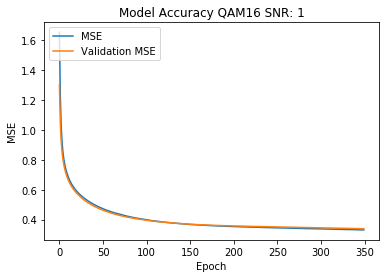

QAM16
X
 [[ 1.94034093  0.59750598]
 [-0.90499688  0.25664845]
 [-1.73407603  0.29304987]
 ...
 [-0.85863813  0.12390668]
 [ 0.59378074 -0.6956671 ]
 [ 0.46846248  0.80329292]] 
Y
 [[ 1.70623341  0.49231351 -0.22796874 -1.94999753]
 [ 1.44973997  1.93968407 -0.74635431 -0.96634775]
 [ 0.97968561  1.17768266 -0.09086857 -1.88735262]
 ...
 [ 0.69115321  2.00153666 -0.3716772  -0.62095044]
 [-2.78142502  0.11548033  0.24161473  0.58620048]
 [ 3.17220425 -0.43361262 -0.60100824  1.17391661]]


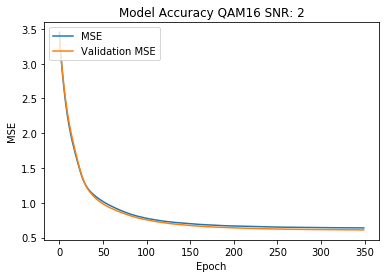

QAM16
X
 [[ 0.67874134  0.0453691 ]
 [ 0.40823566 -0.80014264]
 [-0.2944517   1.12542474]
 ...
 [-1.48847679 -0.21083979]
 [ 0.76621085 -1.19472362]
 [ 0.22593192  0.42240015]] 
Y
 [[ 0.36942007  3.22897671  0.27086083  0.0428042 ]
 [-5.04307142 -1.12811663  1.11603536  2.19989472]
 [ 6.78912968 -3.12460941  2.2341371   3.15778923]
 ...
 [-1.35467546  2.51729537  0.75520311 -3.26492827]
 [-6.71049047 -2.96915895  2.84378593 -0.79084165]
 [ 3.21756717  2.26120057  1.2409754   3.19918128]]


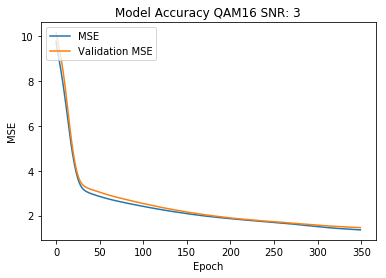

QAM16
X
 [[ 1.02640968  0.86714763]
 [ 0.72509183 -0.54451995]
 [-1.13116165  0.55277601]
 ...
 [-0.89684889 -0.2111612 ]
 [ 0.7898909  -0.39074762]
 [ 0.43590077  0.09567507]] 
Y
 [[15.18669206 -5.7119932  -5.71387781 -8.00566165]
 [-8.21370879  2.54901592 -2.50849016 -1.34768665]
 [ 9.33189816  3.02655955 -3.00378978 -7.88463207]
 ...
 [-5.572055    8.96393857  5.43897287 -5.84252472]
 [-7.432033    5.893175   -5.45070203 -3.42530303]
 [ 2.56439642  9.10660978  2.52838373  4.84373324]]


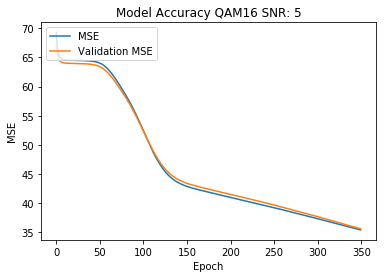

QAM16
X
 [[ 0.93054841  0.4155023 ]
 [ 0.46743113 -1.04605095]
 [-0.92567701  0.19714395]
 ...
 [-1.18945291 -0.40186382]
 [ 0.92091915 -1.20954123]
 [-0.07917108  0.1716063 ]] 
Y
 [[  92.97607482   69.39666965   69.39666953  -71.44988403]
 [-179.48590879  -84.17237229   84.17171023   56.66494203]
 [  54.89580814   93.93951227  -54.89580814  -65.30335233]
 ...
 [ -80.46605705   61.45246659   61.45246386  -94.84152305]
 [-190.57027092  -94.61224507   94.61224507  -57.68809343]
 [  38.09330696   81.54477628  -20.46042255   91.41911016]]


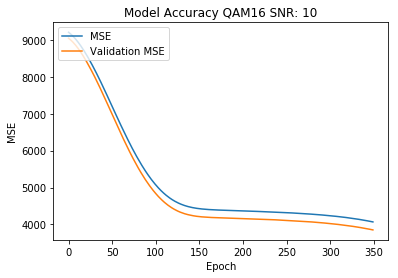

QAM16
X
 [[ 1.04676997  0.29806415]
 [ 0.35156105 -0.94832615]
 [-1.03133036  0.27519202]
 ...
 [-0.9447942  -0.34862622]
 [ 0.95152115 -1.05273152]
 [-0.01245918 -0.0274391 ]] 
Y
 [[ 329.99099911  370.40490375  329.99099911 -376.61681923]
 [-704.72097299 -321.90347102  321.90347102  342.13873127]
 [ 312.03475126  378.74715728 -312.03475126 -364.34800819]
 ...
 [-360.06148902  342.55458288  342.55457513 -318.39928686]
 [-755.4289952  -372.98114689  372.98114689 -315.20351063]
 [ -22.68776805  333.52951606   10.54251531  339.15905229]]


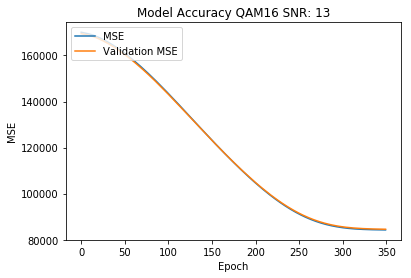

QAM16
X
 [[ 1.02021042  0.33285643]
 [ 0.35721004 -0.98807435]
 [-0.97057055  0.3099676 ]
 ...
 [-0.98453379 -0.35677838]
 [ 0.98401845 -1.01167639]
 [-0.05623646  0.00837733]] 
Y
 [[ 932.38526215  933.76067518  931.91491548 -961.78880152]
 [         -inf -906.71498182  906.71498182  889.00496831]
 [ 874.84521238  942.1987854  -874.84521238 -865.74424942]
 ...
 [-955.34993997  887.72005287  887.72005287 -899.57152082]
 [         -inf -950.3589902   950.3589902  -910.33657476]
 [  18.58658762           inf  -18.58658762           inf]]


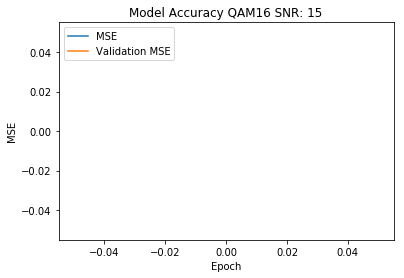

QAM16
X
 [[ 1.00338751  0.32730583]
 [ 0.3288895  -1.01280261]
 [-0.99128937  0.32352377]
 ...
 [-0.99268771 -0.33370283]
 [ 1.01527142 -0.99342875]
 [-0.0039291   0.00233892]] 
Y
 [[ inf  inf  inf -inf]
 [-inf -inf  inf  inf]
 [ inf  inf -inf -inf]
 ...
 [-inf  inf  inf -inf]
 [-inf -inf  inf -inf]
 [ nan  nan  nan  nan]]


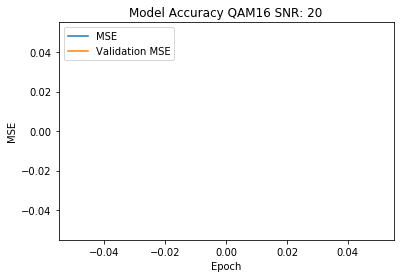

QAM64
X
 [[ -8.63614243 -13.77010227]
 [ -0.73385146  -4.05837344]
 [  7.76231965   0.96421134]
 ...
 [ 11.98396151  -3.56432695]
 [ -2.16326366 -14.07181005]
 [ -7.32101295   8.86569913]] 
Y
 [[-1.39624695e-02  4.79485168e-05  1.20587896e-05 -7.57995596e-05
   1.94535569e-04  4.86642419e-05]
 [-1.60303061e-02  1.53896034e-05  4.76773685e-06 -1.05219926e-04
   1.11436822e-03  2.73932416e-04]
 [ 2.03669776e-03  5.94298250e-04  1.47816727e-04 -3.89342609e-05
  -3.30639497e-05 -8.20053694e-06]
 ...
 [-4.70408013e-03  3.42553196e-04  8.55257496e-05  5.75098505e-05
  -1.19574916e-05 -2.92857070e-06]
 [-1.62799603e-02 -3.76776548e-05 -9.40583567e-06 -2.84236923e-05
   3.22490295e-04  8.04985022e-05]
 [ 1.27071415e-02  1.37583269e-04  3.46075793e-05  1.11889737e-04
   2.23847315e-04  5.61270087e-05]]


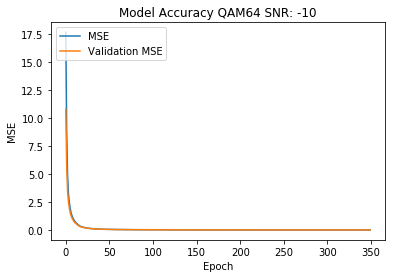

QAM64
X
 [[ 4.48874137 -3.224151  ]
 [-6.22480668 -1.85965542]
 [-3.20938621  3.02004684]
 ...
 [-2.48162031 -1.43093369]
 [ 4.69955006 -1.13670519]
 [-4.99082592 -0.54724135]] 
Y
 [[-9.65513135e-02  3.94891334e-03  1.00716831e-03  3.06757979e-03
  -2.53760999e-04 -3.63336613e-05]
 [-4.75000456e-02  6.30535558e-03  1.56550914e-03 -1.59695948e-03
  -3.65538585e-03 -9.07677722e-04]
 [ 1.13176084e-01  3.30919613e-03  8.76160950e-04  3.75419206e-03
   2.38217108e-03  6.46162140e-04]
 ...
 [-8.31708805e-02  1.09403553e-02  2.81935348e-03 -4.12009148e-03
   5.78556681e-04  2.55583590e-04]
 [-3.91406364e-02  9.04134678e-03  2.22790320e-03  1.56998442e-03
  -3.71773824e-03 -9.19087395e-04]
 [-1.81524827e-02  9.34780121e-03  2.29447826e-03 -7.26227968e-04
  -4.31444962e-03 -1.07513085e-03]]


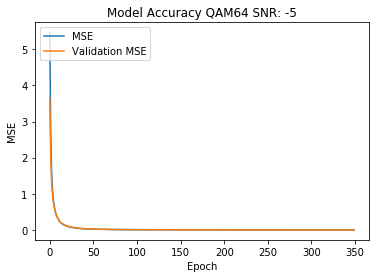

QAM64
X
 [[ 0.2715181   3.37659737]
 [-1.18008279  2.58302257]
 [-2.35802726  1.3903742 ]
 ...
 [ 1.22595981  3.24272116]
 [ 2.27286827  0.77967258]
 [-0.65334885  2.65649389]] 
Y
 [[ 0.64226395 -0.0678186  -0.01704997 -0.00540464  0.05780811  0.01344335]
 [ 0.58988393 -0.04830082 -0.01151809  0.02708276  0.04148031  0.01076243]
 [ 0.34468858  0.02941227  0.00840992  0.0276814  -0.03807444 -0.00864209]
 ...
 [ 0.60793014 -0.05605406 -0.01380493 -0.02181772  0.03848556  0.00958783]
 [ 0.22340301  0.06443728  0.01571488 -0.01866629 -0.05226985 -0.01244946]
 [ 0.62230659 -0.0597507  -0.01468094  0.01721479  0.06372135  0.01495301]]


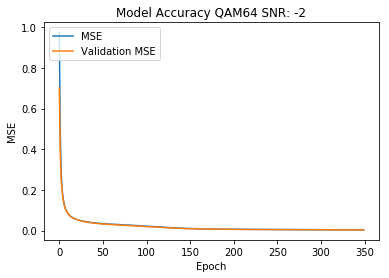

QAM64
X
 [[ 1.19980035  0.81078433]
 [-2.45211641  0.70522953]
 [-0.33997458  1.1708886 ]
 ...
 [ 0.79365086  1.32148776]
 [ 1.92991991 -0.27509451]
 [ 0.21761265  1.39715628]] 
Y
 [[ 1.65325891 -0.09104997  0.1242434  -0.16716812 -0.59654014 -0.13000089]
 [ 0.8205156   0.1958753   0.05073325  0.11629519 -0.81378054 -0.23434876]
 [ 2.23527827 -0.59343812 -0.11544398  0.20490595  0.64932311  0.10291311]
 ...
 [ 2.2572844  -0.64317128 -0.15523326 -0.33586301 -0.0140837   0.11346464]
 [-0.42882833  0.4492869   0.06682117  0.04844679 -0.79334084 -0.22176359]
 [ 2.33847318 -0.68779785 -0.16734601 -0.12826279  0.65935771  0.04932645]]


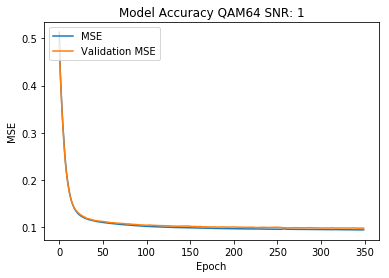

QAM64
X
 [[ 1.00901239 -0.21285149]
 [-1.05479499  0.21337366]
 [-0.44904154  1.90323131]
 ...
 [-0.84003892  1.1677762 ]
 [ 1.19684574 -1.76910069]
 [ 0.73425322  1.43623014]] 
Y
 [[-0.98969313  1.43145305 -0.12928154 -0.05051819 -1.11019441 -0.16649196]
 [ 0.97150264  1.40461877 -0.11431573 -0.03889843 -1.18470672 -0.2304338 ]
 [ 3.89712121 -1.60388932 -0.52431853  0.4048406   0.53183213  0.11189554]
 ...
 [ 3.57826108 -1.34331375 -0.35996208  0.67970669 -0.58574359  0.20343347]
 [-3.67381968 -1.45164111 -0.45050701  0.70244374 -0.65892403 -0.06128906]
 [ 3.73865152 -1.48298913 -0.45530463 -0.66052196 -0.08283874  0.22769282]]


In [ ]:
#Generate randomized data now
#Separate into training and test data
%matplotlib inline
from random import choice
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
RAND_DATA_CREATE = 64**2
#RAND_DATA_CREATE = 8
RAYLEIGH_FADING = np.complex64(1.0)

'''
myqam4 = QAM(NUM_SYMBOLS=4)
myqam16 = QAM(NUM_SYMBOLS=16)
myqam64 = QAM(NUM_SYMBOLS=64)
myBPSK = PSK(NUM_SYMBOLS = 2)
myPSK8 = PSK(NUM_SYMBOLS = 16)
'''
#Signals have a max amplitude of 1.
#SNR = Si - No #db
#SNR = Si - sqrt(VAR)
#VAR = (Si - SNR)**2. Assume Si = 1 (Most likely not the case)

#SNR = Si/sqrt(VAR)
#sqrt(VAR) = Si/SNR

SNRS = [-10, -5, -2, 1, 2, 3, 5, 10, 13, 15, 20]
#SNRS = [-10, -2, 1, 4, 8]
VARS = []
VAR_RAYLEIGH = 1.0

for snr in SNRS:
    snr_linear = 10**(snr / 10)
    VARS.append((1/snr_linear)**2)

print('noise_variance:' , VARS)
    
myModems = [myqam4, myqam16, myqam64, myBPSK, myPSK8]
names = ['QAM', 'QAM16', 'QAM64', 'BPSK', 'PSK8']
num_syms = [4,      16,     64,     2,        8]
num_bits = [ k for k in (np.int_(num_syms)) ]
#losses = ['categorical_crossentropy']
history_list = []
#print(num_bits)
model_list = []
data = ''.join(choice('01') for _ in range(RAND_DATA_CREATE))
Adam=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnt_index = 0
#print('qam64dict: ', myqam64.dict)
for modem in myModems:
    for noise_var, snr in zip(VARS, SNRS):
        print(names[cnt_index])
        channel = rayleigh_multipath(noise_var, VAR_RAYLEIGH, [1.0, 0.7, 0.1, 0.3])
        myModel = generateModel(bps = modem.bit_num)
        #Process the data such that I'm sending an even number of bits through the modulator
        if (names[cnt_index] != 'BPSK'):
            length = len(data)
            num_chunks = int(np.floor_divide(length, modem.bit_num))
            proc_data = data[:length*num_chunks]
        else:
            proc_data = data
        #print('proc_data',len(proc_data),' num_chunks: ', num_chunks)
        
        #Add AWGN and Rayleigh fading through the channel
        X_pre = (channel.awgn(modem.TX(proc_data)))
        #X_pre = channel.apply_cir(X_pre)
        X = []
        for x in X_pre:
            X.append([x.real, x.imag])
        X = np.array(X)
        y = []
        for symbol in X:
            complex_symbol = symbol[0] + 1j*symbol[1]
            #Calculate the LLRs based off of the known approximate rayleigh and gaussian variances
            y.append(calc_llr(modem.dict, complex_symbol, h=VAR_RAYLEIGH, var = noise_var))
        y = np.array(y)
        print('X\n', X, '\nY\n', y)
        #print('Xshape\n', X.shape, '\nYshape\n', y.shape)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        #print('X_train\n', X_train, '\nY_train\n', y_test)
        #print('X_test\n', X_test, '\nY_test\n', y_test)
        myModel.compile(loss='mean_squared_error', optimizer=Adam, metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'accuracy'])
        history=myModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=350, verbose=0)
        history_list.append(history)

        model_list.append(myModel)
        fig = plt.figure()
        
        plt.plot(history.history['mean_squared_error'])
        plt.plot(history.history['val_mean_squared_error'])
        plt.title('Model Accuracy %s SNR: %s' % (names[cnt_index], snr))
        plt.ylabel('MSE')
        plt.xlabel('Epoch')
        plt.legend(['MSE', 'Validation MSE'], loc = 'upper left')
        plt.show()
        
    cnt_index += 1

In [391]:
#Debug BPSK

BPSK_model = model_list[3]
print('BPSK negative:' , BPSK_model.predict(np.array([[-9.0, 0.0]])))
print('BPSK positive:' , BPSK_model.predict(np.array([[1.0, 0.0]])))

BPSK negative: [[22.902063]]
BPSK positive: [[-2.8858914]]


In [ ]:
Adam=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='cross-entropy', optimizer='Adam', metrics=['accuracy'])
training_data = np.array(X_train)
test_data = np.array(X_test)

#Run model. Make sure to regen this model to prevent overfitting
history=model.fit(training_data, y_train, validation_data=(test_data, y_test), epochs=130)
history_list.append(history)